# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

This notebook will be divided in several blocks

    Data load
    Data cleaning
    Perform PCA
    K-Means model
    Conclusions

In [1]:
%load_ext autoreload
%autoreload 2  # Autoreload all modules

In [2]:
# sagemaker libraries
import boto3
import sagemaker
from sagemaker import get_execution_role

from sagemaker.content_types import CONTENT_TYPE_CSV

In [3]:
# import general libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
import mxnet as mx
import ast
import matplotlib.pyplot as plt
import mxnet as mx

from sklearn.preprocessing import MinMaxScaler
# magic word for producing visualizations in notebook
%matplotlib inline

#Import custom libraries
from data_loading import list_csv_files, load_dataframe_from_s3, read_config
from data_cleaning import (dropMissingColumns, getVariances, dropLowVarianceCols, getVariancesLowerThan,
dropColumnsWithUniqueValues, replaceForNan, timestampToFloat, to_category, to_int, impute_mode_categorical,
impute_median_numerical, encodeColumnByLabel, timestampToInt)
from memory_dataframe import memory_usage
from feature_selection import unzipModel, explained_variance
from data_visualization import display_component, display_null_distribution, display_variance_distribution
from csv_transformation import csvToDataFrame, readKmeanResultToDF
from model_selection import loadModelByGroupNumber
from import_management import update_library

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

## Part 1: Customer Segmentation Report

It is necessary to use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Data load

Read the config

In [4]:
config = read_config('config_data')

In [5]:
# boto3 client to get S3 data
s3_client = boto3.client('s3')
bucket_name= config['bucket_name']

Make a list withe files in the bucket and print the file names to be sure that we will be retrieving from the correct location and obtain

In [6]:
# get a list of objects in the bucket
obj_list=s3_client.list_objects(Bucket=bucket_name)
#filter the list with to get only csv
filtered_list = list_csv_files(obj_list)
# print csv objects in in S3 bucket  
print(filtered_list)

['Capstone/Udacity_AZDIAS_052018.csv', 'Capstone/Udacity_CUSTOMERS_052018.csv', 'Capstone/Udacity_MAILOUT_052018_TEST.csv', 'Capstone/Udacity_MAILOUT_052018_TRAIN.csv', 'arvato/azdias.csv', 'arvato/customers.csv', 'arvato/transform/pca/transform/test/azdias.csv.out', 'arvato/transform/pca/transform/test/customers.csv.out', 'mailout-xgboost/mailout_test.csv', 'mailout-xgboost/mailout_train.csv', 'mailout-xgboost/mailout_validation.csv', 'mailout/transform/test/mailout_test.csv.out']


In [7]:
customers_df = None
customers_df = load_dataframe_from_s3(s3_client, bucket_name, filtered_list[1])
customers_df.head()

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [8]:
azdias_df = None
azdias_df = load_dataframe_from_s3(s3_client, bucket_name, filtered_list[0])
azdias_df.head()

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


### 1.2 Data cleaning

First take an overall look to the statistical caracteristics of the data

In [9]:
display(customers_df.describe())

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95825.500000,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,0.000000,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47912.750000,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95825.500000,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143738.250000,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191651.000000,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [10]:
display(azdias_df.describe())

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,891221.000000,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,445610.000000,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,257273.486465,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,0.000000,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,222805.000000,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,445610.000000,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,668415.000000,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,891220.000000,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


#### 1.2.1 Display nulls

In [11]:
rows = azdias_df.shape[0]
missing_values_azdias = azdias_df.isnull().sum().sort_values(ascending = False).divide(other = (rows/100))

display(missing_values_azdias)

ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_KONSUMTYP                  28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_LOTTO                      28.849522
KBA05_SEG8                     14.959701
KBA05_SEG7                     14.959701
KBA05_KW2                      14.959701
KBA05_KW3                      14.959701
KBA05_MAXAH                    14.959701
KBA05_MAXBJ                    14.959701
KBA05_MAXHERST                 14.959701
KBA05_MAXSEG                   14.959701
KBA05_MAXVORB   

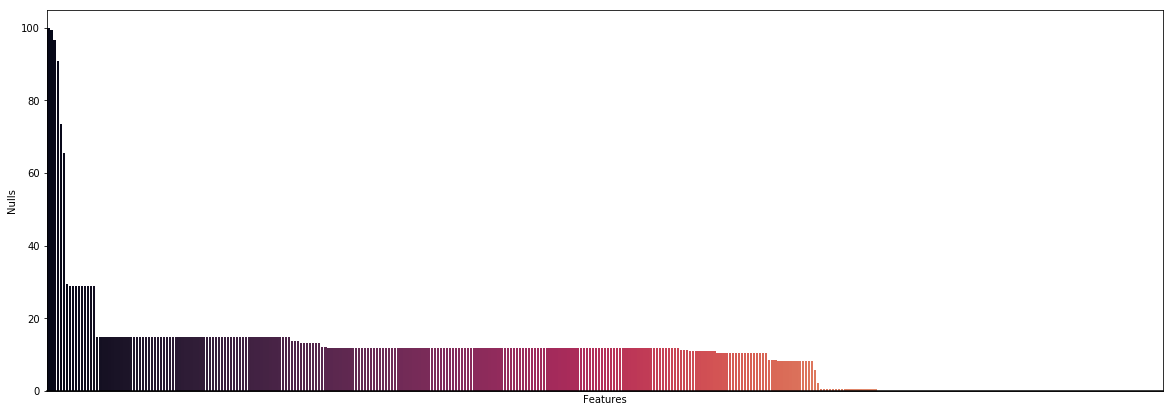

In [12]:
display_null_distribution(missing_values_azdias)

#### 1.2.2 Discard the columns that have more than 28% of null values

As we can see from the list and the graph above the majority of the columns have less than 28% of null values so we only will get rid of the columns that have more than that amount as a threshold.

In [13]:
#make a dict with the names of the columns and then drop this columns from dataframe
drop_columns = missing_values_azdias[missing_values_azdias > 28]

azdias_df.drop(columns = list(drop_columns.index), axis = 1, inplace = True)

azdias_df.shape

(891221, 351)

#### 1.2.3 Discard the columns with low variance

First we have to determine the threshold to drop features

In [14]:
variances = getVariances(azdias_df)

To avoid a graph with very different values first we list the high variable features to determine which variables include in the graphic

In [15]:
variances[variances > 4].sort_values(ascending = False)

LNR                           257273.486465
Unnamed: 0                    257273.486465
GEBURTSJAHR                      976.583551
KBA13_ANZAHL_PKW                 340.034318
ANZ_HAUSHALTE_AKTIV               15.628087
ANZ_STATISTISCHE_HAUSHALTE        14.332201
LP_LEBENSPHASE_FEIN               12.616883
GEMEINDETYP                       12.037852
VERDICHTUNGSRAUM                   8.471520
ALTER_HH                           7.639683
EINGEZOGENAM_HH_JAHR               7.058204
PRAEGENDE_JUGENDJAHRE              4.844532
dtype: float64

So 4 seems a good threshold to plot the graph

In [16]:
variances = getVariancesLowerThan(azdias_df,4)

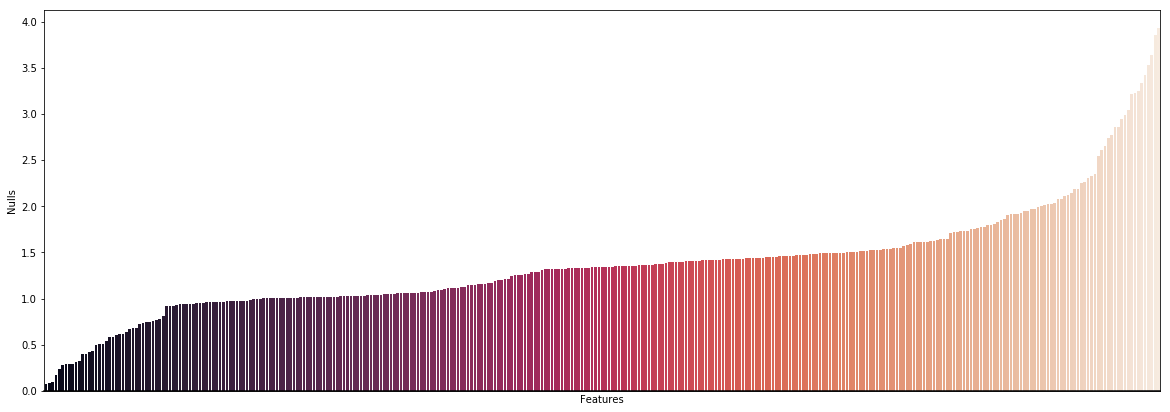

In [17]:
display_variance_distribution(variances)

Columns with less than 0.5 variance are the tail so we take this value as a threshold to drop columns with low variance

In [18]:
dropLowVarianceCols(azdias_df, threshold = 0.5)

Dropping columns:  ANZ_HH_TITEL              0.324028
ANZ_TITEL                 0.068855
D19_TELKO_ANZ_12          0.277552
D19_TELKO_ANZ_24          0.393587
D19_TELKO_ONLINE_DATUM    0.241035
D19_VERSI_ANZ_12          0.434877
D19_VERSI_ONLINE_DATUM    0.311191
DSL_FLAG                  0.176488
GREEN_AVANTGARDE          0.397437
HH_DELTA_FLAG             0.290075
KBA13_KRSSEG_KLEIN        0.292661
KONSUMZELLE               0.424725
SOHO_KZ                   0.091392
TITEL_KZ                  0.084957
UNGLEICHENN_FLAG          0.286278
ANREDE_KZ                 0.499512
dtype: float64


Index(['ANZ_HH_TITEL', 'ANZ_TITEL', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_ONLINE_DATUM', 'D19_VERSI_ANZ_12', 'D19_VERSI_ONLINE_DATUM',
       'DSL_FLAG', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KBA13_KRSSEG_KLEIN',
       'KONSUMZELLE', 'SOHO_KZ', 'TITEL_KZ', 'UNGLEICHENN_FLAG', 'ANREDE_KZ'],
      dtype='object')

In [19]:
azdias_df.shape


(891221, 335)

In [20]:
print('Memory used:', memory_usage(azdias_df), 'Mb')


Memory used: 2486.31 Mb


In [21]:
print(list(azdias_df.columns.values))

['Unnamed: 0', 'LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_KINDER', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'BALLRAUM', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_

#### 1.2.4 Replace for NaN values that are not correct

In [22]:
replaceForNan(azdias_df)

#### 1.2.5 Convert to categorical columns that are of this type

It is necessary to reduce the size of the dataframe in order to optimize the memory usage. Looking to the documentation that explains the type of data of each feature and the possible values I have done a list of the features that are categorical although most of them contain numerical values.

In [23]:
categorical_columns = [
                        'ALTERSKATEGORIE_GROB','AGER_TYP','ALTER_HH',
                      'BALLRAUM','CAMEO_DEUG_2015','CAMEO_DEU_2015','D19_BANKEN_ANZ_24',
                      'CJT_GESAMTTYP','D19_BANKEN_ANZ_12','D19_BANKEN_DATUM',
                      'D19_BANKEN_OFFLINE_DATUM',
                      'D19_BANKEN_ONLINE_DATUM','D19_BANKEN_DIREKT','D19_BANKEN_GROSS',
                      'D19_BANKEN_LOKAL','D19_BANKEN_REST',
                      'D19_BEKLEIDUNG_GEH','D19_BEKLEIDUNG_REST','D19_BILDUNG',
                      'D19_BIO_OEKO','D19_BUCH_CD','D19_DIGIT_SERV','D19_DROGERIEARTIKEL',
                      'D19_ENERGIE','D19_FREIZEIT','D19_GARTEN','D19_GESAMT_ANZ_12',
                      'D19_GESAMT_ANZ_24','D19_GESAMT_DATUM','D19_GESAMT_OFFLINE_DATUM','D19_GESAMT_ONLINE_DATUM',
                      'D19_HANDWERK','D19_HAUS_DEKO','D19_KINDERARTIKEL',
                      'D19_KONSUMTYP_MAX','D19_KOSMETIK','D19_LEBENSMITTEL','D19_NAHRUNGSERGAENZUNG',
                      'D19_RATGEBER','D19_REISEN','D19_SAMMELARTIKEL','D19_SCHUHE','D19_SONSTIGE',
                      'D19_TECHNIK','D19_TELKO_DATUM',
                      'D19_TELKO_MOBILE','D19_TELKO_OFFLINE_DATUM',
                       'D19_TELKO_REST','D19_TIERARTIKEL','D19_VERSAND_ANZ_12',
                      'D19_VERSAND_ANZ_24','D19_VERSAND_DATUM','D19_VERSAND_DATUM',
                      'D19_VERSAND_ONLINE_DATUM','D19_VERSAND_REST','D19_VERSICHERUNGEN',
                      'D19_VERSI_ANZ_24','D19_VOLLSORTIMENT','D19_WEIN_FEINKOST','EWDICHTE',
                      'FINANZTYP','FINANZ_ANLEGER','FINANZ_HAUSBAUER','FINANZ_MINIMALIST',
                      'FINANZ_SPARER','FINANZ_UNAUFFAELLIGER','FINANZ_VORSORGER',
                      'GEBAEUDETYP','GEBAEUDETYP_RASTER','GFK_URLAUBERTYP',
                      'STRUKTURTYP','HEALTH_TYP',
                      'HH_EINKOMMEN_SCORE','INNENSTADT','KBA05_ALTER1','KBA05_ALTER2',
                      'KBA05_ALTER3','KBA05_ALTER4','KBA05_ANHANG','KBA05_ANTG1','KBA05_ANTG2',
                      'KBA05_ANTG3','KBA05_ANTG4','KBA05_AUTOQUOT','KBA05_BAUMAX','KBA05_CCM1',
                    'KBA05_CCM2','KBA05_CCM3','KBA05_CCM4','KBA05_DIESEL','KBA05_FRAU','KBA05_GBZ',
                    'KBA05_HERST1','KBA05_HERST2','KBA05_HERST3','KBA05_HERST4','KBA05_HERST5',
                    'KBA05_HERSTTEMP','KBA05_KRSAQUOT','KBA05_KRSHERST1','KBA05_KRSHERST2',
                    'KBA05_KRSHERST3','KBA05_KRSKLEIN','KBA05_KRSOBER','KBA05_KRSVAN',
                    'KBA05_KRSZUL','KBA05_KW1','KBA05_KW2','KBA05_KW3','KBA05_MAXAH','KBA05_MAXBJ',
                    'KBA05_MAXHERST','KBA05_MAXSEG','KBA05_MAXVORB','KBA05_MOD1','KBA05_MOD2',
                    'KBA05_MOD3','KBA05_MOD4','KBA05_MOD8','KBA05_MODTEMP','KBA05_MOTOR',
                    'KBA05_MOTRAD','KBA05_SEG1','KBA05_SEG10','KBA05_SEG2','KBA05_SEG3',
                    'KBA05_SEG4','KBA05_SEG5','KBA05_SEG6','KBA05_SEG7','KBA05_SEG8','KBA05_SEG9',
                    'KBA05_VORB0','KBA05_VORB1','KBA05_VORB2','KBA05_ZUL1','KBA05_ZUL2',
                    'KBA05_ZUL3','KBA05_ZUL4','KBA13_ALTERHALTER_30','KBA13_ALTERHALTER_45',
                    'KBA13_ALTERHALTER_60','KBA13_ALTERHALTER_61','KBA13_AUDI','KBA13_AUTOQUOTE',
                    'KBA13_BJ_1999','KBA13_BJ_2000','KBA13_BJ_2004','KBA13_BJ_2006',
                    'KBA13_BJ_2008','KBA13_BJ_2009','KBA13_BMW','KBA13_CCM_1000','KBA13_CCM_1200',
                    'KBA13_CCM_1400','KBA13_CCM_0_1400','KBA13_CCM_1500','KBA13_CCM_1401_2500',
                    'KBA13_CCM_1600','KBA13_CCM_1800','KBA13_CCM_2000','KBA13_CCM_2500',
                    'KBA13_CCM_2501','KBA13_CCM_3000','KBA13_CCM_3001','KBA13_FAB_ASIEN',
                    'KBA13_FAB_SONSTIGE','KBA13_FIAT','KBA13_FORD','KBA13_HALTER_20',
                    'KBA13_HALTER_25','KBA13_HALTER_30','KBA13_HALTER_35','KBA13_HALTER_40',
                    'KBA13_HALTER_45','KBA13_HALTER_50','KBA13_HALTER_55','KBA13_HALTER_60',
                    'KBA13_HALTER_65','KBA13_HALTER_66','KBA13_HERST_ASIEN','KBA13_HERST_AUDI_VW',
                    'KBA13_HERST_BMW_BENZ','KBA13_HERST_EUROPA','KBA13_HERST_FORD_OPEL',
                    'KBA13_HERST_SONST','KBA13_KMH_110','KBA13_KMH_140','KBA13_KMH_180',
                    'KBA13_KMH_0_140','KBA13_KMH_140_210','KBA13_KMH_211','KBA13_KMH_250',
                    'KBA13_KMH_251','KBA13_KRSAQUOT','KBA13_KRSHERST_AUDI_VW',
                    'KBA13_KRSHERST_BMW_BENZ','KBA13_KRSHERST_FORD_OPEL',
                    'KBA13_KRSSEG_OBER','KBA13_KRSSEG_VAN','KBA13_KRSZUL_NEU','KBA13_KW_30',
                    'KBA13_KW_40','KBA13_KW_50','KBA13_KW_60','KBA13_KW_0_60','KBA13_KW_70',
                    'KBA13_KW_61_120','KBA13_KW_80','KBA13_KW_90','KBA13_KW_110','KBA13_KW_120',
                    'KBA13_KW_121','KBA13_MAZDA','KBA13_MERCEDES','KBA13_MOTOR','KBA13_NISSAN',
                    'KBA13_OPEL','KBA13_PEUGEOT','KBA13_RENAULT','KBA13_SEG_GELAENDEWAGEN',
                    'KBA13_SEG_GROSSRAUMVANS','KBA13_SEG_KLEINST','KBA13_SEG_KLEINWAGEN',
                    'KBA13_SEG_KOMPAKTKLASSE','KBA13_SEG_MINIVANS','KBA13_SEG_MINIWAGEN',
                    'KBA13_SEG_MITTELKLASSE','KBA13_SEG_OBEREMITTELKLASSE','KBA13_SEG_OBERKLASSE',
                    'KBA13_SEG_SONSTIGE','KBA13_SEG_SPORTWAGEN','KBA13_SEG_UTILITIES',
                    'KBA13_SEG_VAN','KBA13_SEG_WOHNMOBILE','KBA13_SITZE_4','KBA13_SITZE_5',
                    'KBA13_SITZE_6','KBA13_TOYOTA','KBA13_VORB_0','KBA13_VORB_1','KBA13_VORB_1_2',
                    'KBA13_VORB_2','KBA13_VORB_3','KBA13_VW','KKK','KONSUMNAEHE','LP_FAMILIE_FEIN',
                    'LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','LP_STATUS_FEIN',
                    'LP_STATUS_GROB','MOBI_REGIO','NATIONALITAET_KZ','ONLINE_AFFINITAET','ORTSGR_KLS9',
                    'OST_WEST_KZ','PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_BAUMAX',
                    'PLZ8_GBZ','PLZ8_HHZ','PRAEGENDE_JUGENDJAHRE','REGIOTYP','RELAT_AB',
                    'RETOURTYP_BK_S','SEMIO_DOM','SEMIO_ERL','SEMIO_FAM','SEMIO_KAEM','SEMIO_KRIT',
                    'SEMIO_KULT','SEMIO_LUST','SEMIO_MAT','SEMIO_PFLICHT','SEMIO_RAT','SEMIO_REL',
                    'SEMIO_SOZ','SEMIO_TRADV','SEMIO_VERT','SHOPPER_TYP',
                    'VERS_TYP','WOHNDAUER_2008','WOHNLAGE','W_KEIT_KIND_HH','ZABEOTYP',
                    'CAMEO_INTL_2015','KBA13_ANTG1','KBA13_GBZ','D19_VERSI_DATUM','RT_UEBERGROESSE']



azdias_df = to_category(azdias_df, categorical_columns)


print('Memory used:', memory_usage(azdias_df), 'Mb')

Memory used: 588.58 Mb


Digging for more space it can be seen that there are columns that are not listed in the csv description

In [24]:
(azdias_df.memory_usage(deep=True) / 1024 ** 2).sort_values(ascending = False)

EINGEFUEGT_AM                 60.686382
KBA13_ANTG3                    6.799477
MOBI_RASTER                    6.799477
RT_SCHNAEPPCHEN                6.799477
RT_KEIN_ANREIZ                 6.799477
AKT_DAT_KL                     6.799477
D19_VERSAND_OFFLINE_DATUM      6.799477
ANZ_HAUSHALTE_AKTIV            6.799477
ANZ_KINDER                     6.799477
ANZ_PERSONEN                   6.799477
ANZ_STATISTISCHE_HAUSHALTE     6.799477
ARBEIT                         6.799477
MIN_GEBAEUDEJAHR               6.799477
KBA13_KMH_210                  6.799477
KOMBIALTER                     6.799477
CJT_KATALOGNUTZER              6.799477
CJT_TYP_1                      6.799477
CJT_TYP_2                      6.799477
CJT_TYP_3                      6.799477
CJT_TYP_4                      6.799477
CJT_TYP_5                      6.799477
CJT_TYP_6                      6.799477
D19_VERSI_OFFLINE_DATUM        6.799477
KBA13_HHZ                      6.799477
KBA13_ANTG2                    6.799477


Convert to categorical this variables that did not appear

In [25]:
categorical_columns2 = ['RT_SCHNAEPPCHEN','RT_KEIN_ANREIZ','ANZ_HAUSHALTE_AKTIV','ANZ_KINDER',
                       'ANZ_PERSONEN','ANZ_STATISTISCHE_HAUSHALTE','ARBEIT','MOBI_RASTER',
                       'D19_VERSI_OFFLINE_DATUM','MIN_GEBAEUDEJAHR','KOMBIALTER',
                       'CJT_KATALOGNUTZER','CJT_TYP_1','CJT_TYP_2','CJT_TYP_3','CJT_TYP_4','CJT_TYP_5',
                        'CJT_TYP_6','KBA13_HHZ','KBA13_KMH_210','KBA13_BAUMAX',
                       'UMFELD_JUNG','EINGEZOGENAM_HH_JAHR','GEMEINDETYP',
                       'GEBURTSJAHR','AKT_DAT_KL','KBA13_ANTG2','D19_VERSAND_OFFLINE_DATUM','UMFELD_ALT',
                       'KBA13_ANTG3','VK_DISTANZ','FIRMENDICHTE','VERDICHTUNGSRAUM',
                       'VK_ZG11','KBA13_ANTG4','VK_DHT4A','VHN','VHA']
print('Memory used:', memory_usage(azdias_df), 'Mb')

Memory used: 588.58 Mb


#### 1.2.6 Drop rows that not have at least 290 (80%) non null values

In [26]:
azdias_df.dropna(thresh=290, inplace = True)
print('Memory used:', memory_usage(azdias_df), 'Mb')

Memory used: 505.23 Mb


#### 1.2.7 Replace nulls and unknown (-1) values with mode or median

In [27]:
display(impute_mode_categorical(azdias_df).head())

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
1,1,910220,2,9.0,0.0,11.0,0.0,2.0,12.0,3.0,...,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,1
2,2,910225,2,9.0,17.0,10.0,0.0,1.0,7.0,3.0,...,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,3
3,3,910226,2,1.0,13.0,1.0,0.0,0.0,2.0,2.0,...,1.0,0.0,7.0,10.0,11.0,6.0,9.0,7.0,3,4
4,4,910241,2,1.0,20.0,3.0,0.0,4.0,3.0,4.0,...,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,3
5,5,910244,3,1.0,10.0,5.0,0.0,1.0,2.0,2.0,...,0.0,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,1


In [28]:
display(impute_median_numerical(azdias_df).head())

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
1,1,910220,2,9.0,0.0,11.0,0.0,2.0,12.0,3.0,...,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,1
2,2,910225,2,9.0,17.0,10.0,0.0,1.0,7.0,3.0,...,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,3
3,3,910226,2,1.0,13.0,1.0,0.0,0.0,2.0,2.0,...,1.0,0.0,7.0,10.0,11.0,6.0,9.0,7.0,3,4
4,4,910241,2,1.0,20.0,3.0,0.0,4.0,3.0,4.0,...,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,3
5,5,910244,3,1.0,10.0,5.0,0.0,1.0,2.0,2.0,...,0.0,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,1


In [29]:
azdias_df.shape

(751331, 335)

#### 1.2.8 One hot encoding of the non ordinal categorical variables

In [30]:
one_hot_list = ['WOHNLAGE','VERS_TYP','SHOPPER_TYP','RETOURTYP_BK_S','PLZ8_BAUMAX','NATIONALITAET_KZ',
                'LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN','KBA05_MODTEMP','KBA05_MAXHERST','KBA05_HERSTTEMP',
                'HEALTH_TYP','GFK_URLAUBERTYP','GEBAEUDETYP','FINANZTYP','D19_KONSUMTYP_MAX',
                'CJT_GESAMTTYP','CAMEO_DEU_2015','AGER_TYP']
azdias_df = pd.get_dummies(azdias_df, columns =one_hot_list)


print('Memory used:', memory_usage(azdias_df), 'Mb')

Memory used: 624.88 Mb


#### 1.2.9 Drop low variance columns, second iteration

Once performed one hot encoded, drop low variance resulting columns that are result of having previous columns with a value that appears few times and it is not statistically relevant

In [31]:
dropLowVarianceCols(azdias_df)
azdias_df.shape

Dropping columns:  ANZ_KINDER            0.485299
WOHNLAGE_0.0          0.005159
WOHNLAGE_1.0          0.229614
WOHNLAGE_2.0          0.333616
WOHNLAGE_3.0          0.466133
WOHNLAGE_4.0          0.379090
WOHNLAGE_5.0          0.291100
WOHNLAGE_7.0          0.412624
WOHNLAGE_8.0          0.110560
VERS_TYP_-1           0.000000
VERS_TYP_1            0.497406
VERS_TYP_2            0.497406
SHOPPER_TYP_-1        0.000000
SHOPPER_TYP_0         0.371447
SHOPPER_TYP_1         0.477413
SHOPPER_TYP_2         0.441425
SHOPPER_TYP_3         0.412968
RETOURTYP_BK_S_1.0    0.362170
RETOURTYP_BK_S_2.0    0.318464
RETOURTYP_BK_S_3.0    0.411980
RETOURTYP_BK_S_4.0    0.357871
RETOURTYP_BK_S_5.0    0.480777
PLZ8_BAUMAX_1.0       0.480413
PLZ8_BAUMAX_2.0       0.289192
PLZ8_BAUMAX_3.0       0.249646
PLZ8_BAUMAX_4.0       0.262719
PLZ8_BAUMAX_5.0       0.334023
NATIONALITAET_KZ_0    0.202955
NATIONALITAET_KZ_1    0.370452
NATIONALITAET_KZ_2    0.272115
                        ...   
CAMEO_DEU_2015_5C   

(751331, 315)

#### 1.2.10 Data encode

Encode into numerical values binary feature OST_WEST_KZ

In [32]:
azdias_df['OST_WEST_KZ'] = encodeColumnByLabel(azdias_df, 'OST_WEST_KZ')

Convert timestamp into an integer formed by year month and day

In [33]:
azdias_df['EINGEFUEGT_AM'] = timestampToInt(azdias_df, 'EINGEFUEGT_AM')

#### 1.2.11 Data scaling

Normalize values before aplying PCA

In [34]:
np_azdias = azdias_df.values

scaler = MinMaxScaler()
scaler.fit(np_azdias)
np_azdias = scaler.transform(np_azdias)


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Store in the dataframe the normalized values

In [35]:
azdias_df = pd.DataFrame(data=np_azdias,
          index=azdias_df.index,
          columns=azdias_df.columns)


### 1.3 Perform PCA

#### 1.3.1 PCA Fit

In [36]:
session = sagemaker.Session()
# get IAM role
role = get_execution_role()
prefix = 'arvato'
output_path='s3://{}/{}/'.format(bucket_name, prefix+"/train")
#num_components = 400
#since removing columns with low variance after performing one hot encoding the remaining number of columns is
#less than the previously specified number of components (316) so I set a new number of components
num_components = 300



pca = sagemaker.PCA(  role = role,
                      train_instance_count = 1,
                      train_instance_type = 'ml.m5.large', 
                      num_components = num_components,
                      sagemaker_session=session,
                      output_path = output_path)

Convert to recordset format

In [37]:
formatted_azdias_data = pca.record_set(np_azdias)

Fit data to PCA

In [38]:
#train_inputs = sagemaker.s3_input(train_s3, content_type='text/csv;label_size=0')

pca.fit(formatted_azdias_data)


2020-05-18 11:28:07 Starting - Starting the training job...
2020-05-18 11:28:09 Starting - Launching requested ML instances......
2020-05-18 11:29:08 Starting - Preparing the instances for training...
2020-05-18 11:29:48 Downloading - Downloading input data......
2020-05-18 11:30:56 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/18/2020 11:30:59 INFO 140131447232320] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[05/18/2020 11:30:59 INFO 140131447232320] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'315', u'mini_batch_size'

[2020-05-18 11:31:11.293] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 1, "duration": 10444, "num_examples": 1503, "num_bytes": 1914391388}
#metrics {"Metrics": {"epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "update.time": {"count": 1, "max": 10452.441930770874, "sum": 10452.441930770874, "min": 10452.441930770874}}, "EndTime": 1589801471.294071, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "PCA"}, "StartTime": 1589801460.8346}

[05/18/2020 11:31:11 INFO 140131447232320] #progress_metric: host=algo-1, completed 100 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 1503, "sum": 1503.0, "min": 1503}, "Number of Batches Since Last Reset": {"count": 1, "max": 1503, "sum": 1503.0, "min": 1503}, "Number of Records Since Last Reset": {"count": 1, "max": 751331, "sum": 751331.0, "min": 751331}, "Total Batches Seen": {"count": 1, "max": 1503, "sum": 1503.0, "min": 1503}, "Total Rec

#### 1.3.2 Feature importance

Unzip model details

In [39]:
unzipModel(pca._current_job_name,bucket_name, prefix+"/train",'model.tar.gz','model_pca')

arvato/train/pca-2020-05-18-11-28-07-757/output/model.tar.gz


Load the model to find the features weights in each component and the optimal number of principal components

In [40]:
# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_pca')

In [41]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

Plot the features weights

In [42]:
N_COMPONENTS = 300

# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 33-n

# print a selection of s
print(s.iloc[start_idx:, :])

               0
295   711.392944
296   911.148010
297   931.654968
298  1067.442993
299  1331.841919


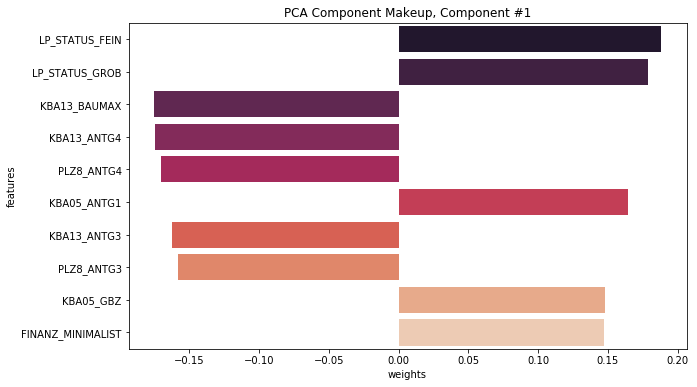

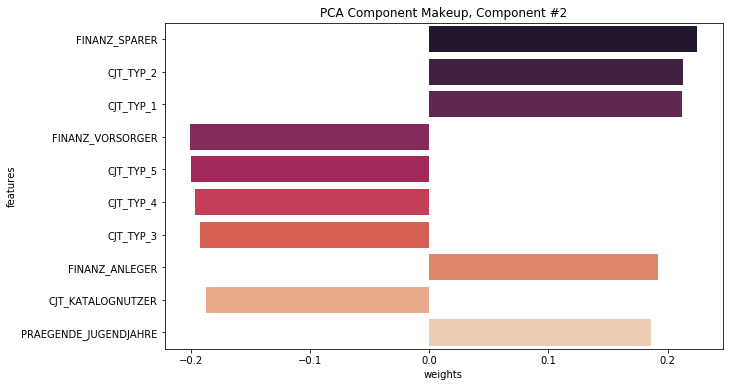

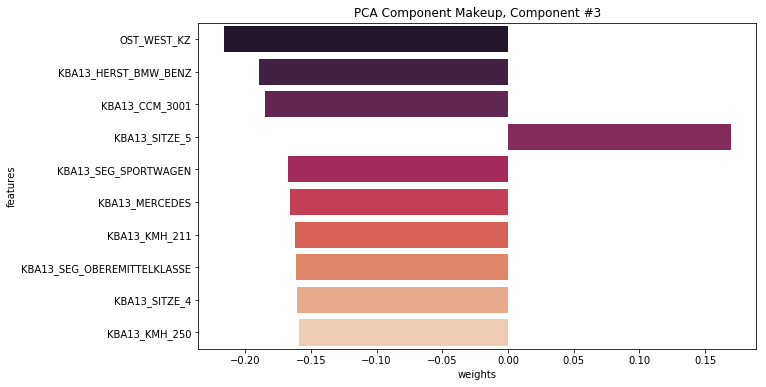

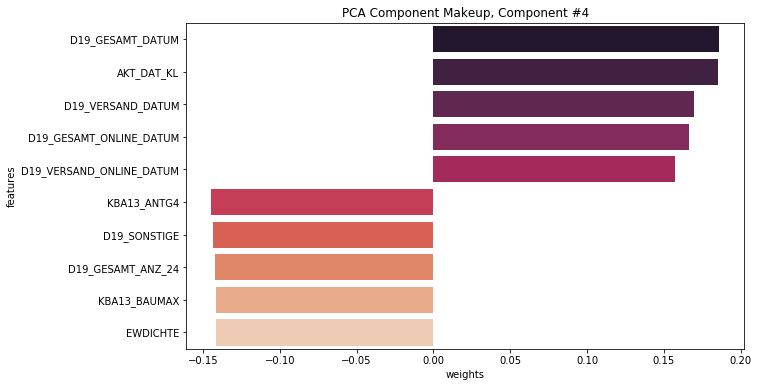

In [43]:
# display makeup of five most important components
for num in range(1,5):
    display_component(v, azdias_df.columns.values, component_num=num, n_components = N_COMPONENTS, n_weights=10)

Plot the explained variance vs number of components 

In [44]:
# test cell
n_top_components = 220 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0    0.980087
dtype: float32


In [45]:
y = []
for x in range(num_components):
    y.append(explained_variance(s, x))

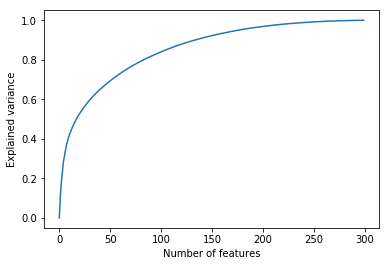

In [46]:
import matplotlib.pyplot as plt
plt.plot(y)
plt.ylabel('Explained variance')
plt.xlabel('Number of features')
plt.show()


Show how many components are needed for 90% of explained variance

In [47]:
#convert list of series to list of floats
floats_y = [float(i) for i in y]
#construct an comprehension to locate the index of the first element with more than 0.9 explained variance
components = (i for i,v in enumerate(floats_y) if (v > 0.9))
num_components = next(components)
print(num_components)

134


#### 1.3.3 Fit PCA with selected component number

Re-fit PCA with the number of components obtained before

In [48]:
pca = sagemaker.PCA(  role = role,
                      train_instance_count = 1,
                      train_instance_type = 'ml.m5.large', 
                      num_components = num_components,
                      sagemaker_session=session,
                      output_path = output_path)

pca.fit(formatted_azdias_data)

2020-05-18 11:31:52 Starting - Starting the training job...
2020-05-18 11:31:53 Starting - Launching requested ML instances...
2020-05-18 11:32:53 Starting - Preparing the instances for training......
2020-05-18 11:33:38 Downloading - Downloading input data......
2020-05-18 11:34:47 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/18/2020 11:34:50 INFO 140248125753152] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[05/18/2020 11:34:50 INFO 140248125753152] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'315', u'mini_batch_size

[2020-05-18 11:35:03.007] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 1, "duration": 10684, "num_examples": 1503, "num_bytes": 1914391388}
#metrics {"Metrics": {"epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "update.time": {"count": 1, "max": 10692.96407699585, "sum": 10692.96407699585, "min": 10692.96407699585}}, "EndTime": 1589801703.008133, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "PCA"}, "StartTime": 1589801692.305957}

[05/18/2020 11:35:03 INFO 140248125753152] #progress_metric: host=algo-1, completed 100 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 1503, "sum": 1503.0, "min": 1503}, "Number of Batches Since Last Reset": {"count": 1, "max": 1503, "sum": 1503.0, "min": 1503}, "Number of Records Since Last Reset": {"count": 1, "max": 751331, "sum": 751331.0, "min": 751331}, "Total Batches Seen": {"count": 1, "max": 1503, "sum": 1503.0, "min": 1503}, "Total Reco

#### 1.3.4  PCA Predictor

In [49]:
%%time

pca_transformer = pca.transformer(instance_count = 1, 
                                  instance_type = 'ml.m5.large',
                                  output_path='s3://{}/{}/pca/transform/test'.format(bucket_name, prefix+"/transform"))



CPU times: user 22.8 ms, sys: 597 µs, total: 23.4 ms
Wall time: 348 ms


In [50]:
del(formatted_azdias_data)

Encode characters

In [51]:
filename = 'azdias.csv'


u = azdias_df.select_dtypes(object)
azdias_df[u.columns] = u.apply(
    lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))



Save csv into local notebook storage

In [52]:
azdias_df.to_csv(filename,header = False,index=False, encoding="utf-8")

Save csv into S3 bucket

In [53]:
data_dir = "data/"

np_azdias_location = session.upload_data(os.path.join(filename), key_prefix=prefix)



Print dataset location in order to avoid previous computation later

In [54]:
print(np_azdias_location)

s3://sagemaker-eu-west-1-848439228145/arvato/azdias.csv


Delete temp file from sagemaker notebook

In [55]:
os.remove(filename)

In [56]:
%%time



pca_transformer.transform(np_azdias_location, content_type=CONTENT_TYPE_CSV, split_type='Line')
pca_transformer.wait()

..................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[05/18/2020 11:43:07 INFO 140684471953216] loaded entry point class algorithm.serve.server_config:config_api
[05/18/2020 11:43:07 INFO 140684471953216] nvidia-smi took: 0.0251579284668 secs to identify 0 gpus
[05/18/2020 11:43:07 INFO 140684471953216] loading entry points
[05/18/2020 11:43:07 INFO 140684471953216] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[05/18/2020 11:43:07 INFO 140684471953216] Loaded iterator creator application/x-labeled-vector-protobuf for content type ('application/x-labeled-vector-protobuf', '1.0')
[05/18/2020 11:43:07 INFO 140684471953216] Loaded iterator creator protobuf for content type ('protobuf', '1.0')
[05/18/2020 11:43:07 INFO 140684471953216] loaded request iterator text/csv
[05/18/2020 11:43:07 INFO 140684471953216] loaded request iterator application/x-recordio-pr

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802217.394836, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802216.112114}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802217.714135, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802216.332667}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802217.394836, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802216.112114}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802217.714135, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802216.332667}

[05/18/2020 11:43:38 WARNING

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802225.029132, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802223.523871}

[05/18/2020 11:43:45 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:43:45 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:43:45 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:43:45 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2479.
[05/18/2020 11:43:45 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:43:45 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:43:45 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:43:45 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch s

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802236.751334, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802234.883968}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802236.751334, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802234.883968}

[05/18/2020 11:43:56 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:43:56 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:43:56 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:43:56 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2481.
[05/18/2020 11:43:57 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/

[05/18/2020 11:44:05 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:44:05 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2473.
[05/18/2020 11:44:06 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:44:06 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:44:05 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:44:05 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2473.
[05/18/2020 11:44:06 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:44:06 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:44:06 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:44:06 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2477.
#metrics {"Metrics": {"inv

[05/18/2020 11:44:21 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:44:21 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:44:21 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2480.
[05/18/2020 11:44:21 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2480.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802261.945225, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802260.718839}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802262.153418, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802260.641133}

[05/18/2020 11:44:22 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802272.182193, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802270.634769}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802272.241185, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802270.860968}

[05/18/2020 11:44:32 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:44:32 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:44:32 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:44:32 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2480.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802272.182193, "Dime

[05/18/2020 11:44:51 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:44:51 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2480.
[05/18/2020 11:44:51 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:44:51 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:44:51 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:44:51 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:44:51 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2480.
[05/18/2020 11:44:51 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:44:51 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:44:51 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:44:51 INFO 140684471953216] <

[05/18/2020 11:45:02 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:45:02 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:45:02 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:45:02 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2492.
[05/18/2020 11:45:02 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:45:02 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:45:02 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:45:02 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2492.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802302.898589, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime":

[05/18/2020 11:45:12 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:45:12 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:45:12 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:45:12 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2498.
[05/18/2020 11:45:12 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:45:12 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:45:12 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:45:12 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2493.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802312.867793, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime":

[05/18/2020 11:45:22 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:45:22 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:45:22 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:45:22 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2484.
[05/18/2020 11:45:22 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:45:22 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:45:22 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:45:22 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2485.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802322.759316, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime":

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802331.94861, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802330.528461}

[05/18/2020 11:45:32 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:45:32 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:45:32 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:45:32 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2483.
[05/18/2020 11:45:32 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:45:32 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:45:32 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:45:32 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch sl

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802342.708507, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802341.335688}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802342.708507, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802341.335688}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802343.091304, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802341.596401}

[05/18/2020 11:45:43 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:45:43 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:45:43 INFO 140684471953216] The default executor is <PCAModel o

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802352.773802, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802351.397907}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802352.910632, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802351.532996}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802352.773802, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802351.397907}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802352.910632, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802351.532996}

[05/18/2020 11:45:53 WARNING

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802361.701609, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802360.157786}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802361.701609, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802360.157786}

[05/18/2020 11:46:02 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:46:02 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:46:02 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:46:02 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:46:02 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:46:02 INFO 1406844719532

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802371.710819, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802370.344969}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802371.710819, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802370.344969}

[05/18/2020 11:46:12 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:46:12 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:46:12 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:46:12 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2496.
[05/18/2020 11:46:12 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/

[05/18/2020 11:46:22 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2481.
[05/18/2020 11:46:22 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2481.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802382.677034, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802381.308547}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802382.677034, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802381.308547}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802382.966342, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802381.569939}

[05/18/2020 11:46:23 WARNING 140684471953216] Requesting 

[05/18/2020 11:46:32 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:46:32 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2491.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802392.467746, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802391.215184}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802392.770246, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802391.400509}

[05/18/2020 11:46:32 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:46:32 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2491.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802392.467746, "D

[05/18/2020 11:46:41 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:46:41 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:46:41 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:46:41 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802401.784291, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802400.42291}

[05/18/2020 11:46:41 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2489.
[05/18/2020 11:46:41 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:46:41 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802411.999651, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802410.722012}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802412.147935, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802410.806736}

[05/18/2020 11:46:52 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:46:52 INFO 140684471953216] Number of GPUs being used: 0
[05/18/2020 11:46:52 INFO 140684471953216] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:46:52 INFO 140684471953216] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2492.
[05/18/2020 11:46:52 WARNING 140684471953216] Requesting context without setting the requested num of gpus. Using 'auto'
[05/


CPU times: user 1.53 s, sys: 148 ms, total: 1.67 s
Wall time: 7min 16s


In [57]:
s3file_uri = 's3://'+bucket_name+'/arvato/transform/pca/transform/test/azdias.csv.out'
!aws s3 cp  $s3file_uri ./


download: s3://sagemaker-eu-west-1-848439228145/arvato/transform/pca/transform/test/azdias.csv.out to ./azdias.csv.out


In [58]:
azdias_sub_pca = pd.DataFrame()

azdias_sub_pca = csvToDataFrame('azdias.csv.out')

print('Memory used:', memory_usage(azdias_sub_pca), 'Mb') 

Memory used: 384.06 Mb


In [59]:
azdias_sub_pca.shape

(751331, 134)

#### 1.3.5 Apply same transformations done on azdias to customers data

In [60]:
customers_df.drop(columns = list(drop_columns.index), axis = 1, inplace = True)

In [61]:
customers_df.dropna(thresh=290, inplace = True)

In [62]:
replaceForNan(customers_df)

In [63]:
customers_df = to_category(customers_df, categorical_columns)

In [64]:
customers_df = to_category(customers_df, categorical_columns2)

print('Memory used:', memory_usage(customers_df), 'Mb')

Memory used: 93.49 Mb


In [65]:
display(impute_mode_categorical(customers_df).head())

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,1.0,0.0,0.0,2.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
2,2,143872,2,1.0,6.0,1.0,0.0,0.0,1.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,0.0,NaN,0.0,0.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,2,1.0,20.0,7.0,0.0,0.0,4.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,5,143888,1,1.0,11.0,1.0,0.0,0.0,2.0,1.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3


In [66]:
display(impute_median_numerical(customers_df).head())

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,1.0,0.0,0.0,2.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
2,2,143872,2,1.0,6.0,1.0,0.0,0.0,1.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,0.0,0.0,0.0,0.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,2,1.0,20.0,7.0,0.0,0.0,4.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,5,143888,1,1.0,11.0,1.0,0.0,0.0,2.0,1.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3


In [67]:
customers_df = pd.get_dummies(customers_df, columns =one_hot_list)

In [68]:
impute_median_numerical(customers_df).head()
impute_mode_categorical(customers_df).head()

,Unnamed: 0,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,AGER_TYP_-1,AGER_TYP_0,AGER_TYP_1,AGER_TYP_2,AGER_TYP_3
0,0,9626,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,2,143872,1.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,3,143873,1.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,4,143874,1.0,20.0,7.0,0.0,0.0,4.0,7.0,0.0,...,0,0,0,0,0,0,0,0,1,0
5,5,143888,1.0,11.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [69]:
customers_df['OST_WEST_KZ'] = encodeColumnByLabel(customers_df, 'OST_WEST_KZ')

In [70]:
customers_df['EINGEFUEGT_AM'] = timestampToInt(customers_df, 'EINGEFUEGT_AM')

In [71]:
customers_df.shape

(137087, 520)

#### 1.3.6 Drop columns that come from one hot encoding that do not exist in azdias and add with zeros the columns that exists in azdias but not in customers

In [72]:
#Drop and add columns

addColumnList = np.setdiff1d(azdias_df.columns,customers_df.columns)
print("Columns to add", addColumnList)

dropColumnList = np.setdiff1d(customers_df.columns, azdias_df.columns)
print("Columns to drop", dropColumnList)

Columns to add []
Columns to drop ['AGER_TYP_-1' 'AGER_TYP_0' 'AGER_TYP_1' 'AGER_TYP_2' 'AGER_TYP_3'
 'ANREDE_KZ' 'ANZ_HH_TITEL' 'ANZ_KINDER' 'ANZ_TITEL' 'CAMEO_DEU_2015_1A'
 'CAMEO_DEU_2015_1B' 'CAMEO_DEU_2015_1C' 'CAMEO_DEU_2015_1D'
 'CAMEO_DEU_2015_1E' 'CAMEO_DEU_2015_2A' 'CAMEO_DEU_2015_2B'
 'CAMEO_DEU_2015_2C' 'CAMEO_DEU_2015_2D' 'CAMEO_DEU_2015_3A'
 'CAMEO_DEU_2015_3B' 'CAMEO_DEU_2015_3C' 'CAMEO_DEU_2015_3D'
 'CAMEO_DEU_2015_4A' 'CAMEO_DEU_2015_4B' 'CAMEO_DEU_2015_4C'
 'CAMEO_DEU_2015_4D' 'CAMEO_DEU_2015_4E' 'CAMEO_DEU_2015_5A'
 'CAMEO_DEU_2015_5B' 'CAMEO_DEU_2015_5C' 'CAMEO_DEU_2015_5D'
 'CAMEO_DEU_2015_5E' 'CAMEO_DEU_2015_5F' 'CAMEO_DEU_2015_6A'
 'CAMEO_DEU_2015_6B' 'CAMEO_DEU_2015_6C' 'CAMEO_DEU_2015_6D'
 'CAMEO_DEU_2015_6E' 'CAMEO_DEU_2015_6F' 'CAMEO_DEU_2015_7A'
 'CAMEO_DEU_2015_7B' 'CAMEO_DEU_2015_7C' 'CAMEO_DEU_2015_7D'
 'CAMEO_DEU_2015_7E' 'CAMEO_DEU_2015_8A' 'CAMEO_DEU_2015_8B'
 'CAMEO_DEU_2015_8C' 'CAMEO_DEU_2015_8D' 'CAMEO_DEU_2015_9A'
 'CAMEO_DEU_2015_9B' 'CAMEO_DEU_2

In [73]:
customers_df.drop(list(dropColumnList), axis='columns', inplace=True)

In [74]:
np_customers = customers_df.values
np_customers = scaler.transform(np_customers)

customers_df = pd.DataFrame(data=np_customers,
          index=customers_df.index,
          columns=customers_df.columns)

#### 1.3.7 Perform PCA transformation on customer data

In [75]:
customers_file = 'customers.csv'

customers_dtypes = customers_df.select_dtypes(object)
customers_df[u.columns] = customers_dtypes.apply(
    lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

customers_df.to_csv(customers_file,header = False,index=False, encoding="utf-8")

In [76]:
data_dir = "data/"

customers_location = session.upload_data(os.path.join(customers_file), key_prefix=prefix)

os.remove(customers_file)

In [77]:
%%time


pca_transformer.transform(customers_location, content_type=CONTENT_TYPE_CSV, split_type='Line')
pca_transformer.wait()

.................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[05/18/2020 11:52:30 INFO 140709036812096] loaded entry point class algorithm.serve.server_config:config_api
[05/18/2020 11:52:30 INFO 140709036812096] nvidia-smi took: 0.0251309871674 secs to identify 0 gpus
[05/18/2020 11:52:30 INFO 140709036812096] loading entry points
[05/18/2020 11:52:30 INFO 140709036812096] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[05/18/2020 11:52:30 INFO 140709036812096] Loaded iterator creator application/x-labeled-vector-protobuf for content type ('application/x-labeled-vector-protobuf', '1.0')
[05/18/2020 11:52:30 INFO 140709036812096] Loaded iterator creator protobuf for content type ('protobuf', '1.0')
[05/18/2020 11:52:30 INFO 140709036812096] loaded request iterator text/csv
[05/18/2020 11:52:30 INFO 140709036812096] loaded request iterator application/x-recordio-pro

[05/18/2020 11:53:09 WARNING 140709036812096] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:53:09 INFO 140709036812096] Number of GPUs being used: 0
[05/18/2020 11:53:09 INFO 140709036812096] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:53:09 INFO 140709036812096] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2394.
[05/18/2020 11:53:09 WARNING 140709036812096] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:53:09 INFO 140709036812096] Number of GPUs being used: 0
[05/18/2020 11:53:09 INFO 140709036812096] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:53:09 INFO 140709036812096] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2394.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802789.331906, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime":

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802799.534447, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802798.207879}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802799.979582, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802798.488366}

[05/18/2020 11:53:20 WARNING 140709036812096] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:53:20 INFO 140709036812096] Number of GPUs being used: 0
[05/18/2020 11:53:20 INFO 140709036812096] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:53:20 INFO 140709036812096] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2403.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802799.534447, "Dime

[05/18/2020 11:53:28 INFO 140709036812096] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:53:28 INFO 140709036812096] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2401.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802808.648151, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1589802807.439897}

[05/18/2020 11:53:29 WARNING 140709036812096] Requesting context without setting the requested num of gpus. Using 'auto'
[05/18/2020 11:53:29 INFO 140709036812096] Number of GPUs being used: 0
[05/18/2020 11:53:29 INFO 140709036812096] The default executor is <PCAModel on cpu(0)>.
[05/18/2020 11:53:29 INFO 140709036812096] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 2400.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589802809.267049, "Dimensions": {"Host": "UNKNOWN", "Operation": "scor


CPU times: user 642 ms, sys: 33.8 ms, total: 676 ms
Wall time: 4min 12s


#### 1.3.8 Copy the transformed data to the notebook

In [78]:
s3file_uri = 's3://'+bucket_name+'/arvato/transform/pca/transform/test/customers.csv.out'
!aws s3 cp  $s3file_uri ./

download: s3://sagemaker-eu-west-1-848439228145/arvato/transform/pca/transform/test/customers.csv.out to ./customers.csv.out


In [79]:
customers_sub_pca = csvToDataFrame('customers.csv.out')

print('Memory used:', memory_usage(customers_sub_pca), 'Mb') 

Memory used: 70.07 Mb


In [80]:
customers_sub_pca.shape

(137087, 134)

### 1.4 K-Means model

In [81]:
k_formatted_azdias_data = pca.record_set(azdias_sub_pca.values.astype('float32'))

#### 1.4.1 Determine how many groups select

Launch jobs from 2 to 12 groups to determine how many groups form

In [82]:
##Launch different jobs
K = range(2, 12) # change the range to be used for k

output_path = 's3://{}/kmeans/output/'.format(bucket_name)
job_names = {}
# launching jobs for all k
for k in K:
    k_estimator = sagemaker.KMeans(role,
                               train_instance_count = 1,
                               train_instance_type = 'ml.m5.large',
                               k = k,
                               output_path = output_path
                              )

    k_estimator.fit(k_formatted_azdias_data)
    job_names[k] = k_estimator._current_job_name



2020-05-18 11:55:00 Starting - Starting the training job...
2020-05-18 11:55:02 Starting - Launching requested ML instances......
2020-05-18 11:56:03 Starting - Preparing the instances for training...
2020-05-18 11:56:43 Downloading - Downloading input data...
2020-05-18 11:57:30 Training - Downloading the training image...
2020-05-18 11:57:43 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/18/2020 11:57:46 INFO 140495631181632] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_i


2020-05-18 11:58:09 Uploading - Uploading generated training model
2020-05-18 11:58:09 Completed - Training job completed
Training seconds: 86
Billable seconds: 86
2020-05-18 11:58:42 Starting - Starting the training job...
2020-05-18 11:58:44 Starting - Launching requested ML instances...
2020-05-18 11:59:42 Starting - Preparing the instances for training......
2020-05-18 12:00:18 Downloading - Downloading input data...
2020-05-18 12:01:01 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/18/2020 12:01:16 INFO 140221426931520] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'


2020-05-18 12:01:31 Uploading - Uploading generated training model
2020-05-18 12:01:31 Completed - Training job completed
Training seconds: 73
Billable seconds: 73
2020-05-18 12:01:54 Starting - Starting the training job...
2020-05-18 12:01:56 Starting - Launching requested ML instances...
2020-05-18 12:02:54 Starting - Preparing the instances for training......
2020-05-18 12:03:30 Downloading - Downloading input data...
2020-05-18 12:04:24 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/18/2020 12:04:27 INFO 140396310918976] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'


2020-05-18 12:04:42 Uploading - Uploading generated training model
2020-05-18 12:04:42 Completed - Training job completed
Training seconds: 72
Billable seconds: 72
2020-05-18 12:05:06 Starting - Starting the training job...
2020-05-18 12:05:08 Starting - Launching requested ML instances......
2020-05-18 12:06:10 Starting - Preparing the instances for training...
2020-05-18 12:06:56 Downloading - Downloading input data......
2020-05-18 12:07:50 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/18/2020 12:08:11 INFO 140663004297024] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1',


2020-05-18 12:08:27 Uploading - Uploading generated training model
2020-05-18 12:08:27 Completed - Training job completed
Training seconds: 91
Billable seconds: 91
2020-05-18 12:08:48 Starting - Starting the training job...
2020-05-18 12:08:51 Starting - Launching requested ML instances......
2020-05-18 12:09:51 Starting - Preparing the instances for training...
2020-05-18 12:10:33 Downloading - Downloading input data...
2020-05-18 12:11:19 Training - Downloading the training image...
2020-05-18 12:11:49 Uploading - Uploading generated training model
2020-05-18 12:11:49 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/18/2020 12:11:34 INFO 139864068175680] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log

Training seconds: 76
Billable seconds: 76
2020-05-18 12:12:00 Starting - Starting the training job...
2020-05-18 12:12:01 Starting - Launching requested ML instances......
2020-05-18 12:13:03 Starting - Preparing the instances for training...
2020-05-18 12:13:48 Downloading - Downloading input data......
2020-05-18 12:14:36 Training - Downloading the training imageDocker entrypoint called with argument(s): train
Running default environment configuration script
[05/18/2020 12:14:54 INFO 140536818595648] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'fals


2020-05-18 12:15:23 Uploading - Uploading generated training model
2020-05-18 12:15:23 Completed - Training job completed
Training seconds: 95
Billable seconds: 95
2020-05-18 12:15:42 Starting - Starting the training job...
2020-05-18 12:15:43 Starting - Launching requested ML instances...
2020-05-18 12:16:42 Starting - Preparing the instances for training.........
2020-05-18 12:17:56 Downloading - Downloading input data...
2020-05-18 12:18:40 Training - Downloading the training image...
2020-05-18 12:19:07 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[05/18/2020 12:18:59 INFO 140202715637568] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd


2020-05-18 12:19:14 Completed - Training job completed
Training seconds: 78
Billable seconds: 78
2020-05-18 12:19:54 Starting - Starting the training job...
2020-05-18 12:19:58 Starting - Launching requested ML instances......
2020-05-18 12:20:57 Starting - Preparing the instances for training...
2020-05-18 12:21:45 Downloading - Downloading input data...
2020-05-18 12:22:24 Training - Downloading the training image...
2020-05-18 12:22:51 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[05/18/2020 12:22:42 INFO 139663842277184] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', 


2020-05-18 12:22:57 Completed - Training job completed
Training seconds: 72
Billable seconds: 72
2020-05-18 12:23:36 Starting - Starting the training job...
2020-05-18 12:23:38 Starting - Launching requested ML instances......
2020-05-18 12:25:04 Starting - Preparing the instances for training......
2020-05-18 12:25:42 Downloading - Downloading input data...
2020-05-18 12:26:27 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/18/2020 12:26:42 INFO 139802601092928] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local


2020-05-18 12:26:57 Uploading - Uploading generated training model
2020-05-18 12:26:57 Completed - Training job completed
Training seconds: 75
Billable seconds: 75
2020-05-18 12:27:18 Starting - Starting the training job...
2020-05-18 12:27:19 Starting - Launching requested ML instances......
2020-05-18 12:28:21 Starting - Preparing the instances for training...
2020-05-18 12:29:03 Downloading - Downloading input data...
2020-05-18 12:29:44 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/18/2020 12:29:59 INFO 140078190008128] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u


2020-05-18 12:30:08 Uploading - Uploading generated training model
2020-05-18 12:30:33 Completed - Training job completed
Training seconds: 90
Billable seconds: 90


In [83]:
print(job_names)

{2: 'kmeans-2020-05-18-11-55-00-438', 3: 'kmeans-2020-05-18-11-58-42-779', 4: 'kmeans-2020-05-18-12-01-54-610', 5: 'kmeans-2020-05-18-12-05-06-483', 6: 'kmeans-2020-05-18-12-08-48-345', 7: 'kmeans-2020-05-18-12-12-00-161', 8: 'kmeans-2020-05-18-12-15-42-297', 9: 'kmeans-2020-05-18-12-19-54-469', 10: 'kmeans-2020-05-18-12-23-36-555', 11: 'kmeans-2020-05-18-12-27-18-602'}


Choose the most appropiate number of groups using the elbow method

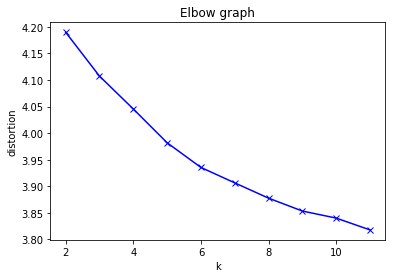

In [84]:
#chunk based on https://aws.amazon.com/blogs/machine-learning/k-means-clustering-with-amazon-sagemaker/

from scipy.spatial.distance import cdist

K = range(2, 12) # change the range to be used for k

plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']
models = {}
distortions = []
for k in K:
    kmeans_model = loadModelByGroupNumber(k,'model.tar.gz', job_names, bucket_name)
    kmeans_numpy = kmeans_model[0].asnumpy()
    distortions.append(sum(np.min(cdist(azdias_sub_pca.values, kmeans_numpy, 'euclidean'), axis=1)) / azdias_sub_pca.values.shape[0])
    models[k] = kmeans_numpy
 
#plot
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('Elbow graph')
plt.show()

#s3://sagemaker-eu-west-1-848439228145/kmeans/output/kmeans-2020-05-06-16-55-36-157/output/model.tar.gz

From the elbow graph it seems that 7 groups are the best option

In [85]:
kmeans_7 = loadModelByGroupNumber(7,'model.tar.gz',job_names, bucket_name)

#### 1.4.2 Refit with 7 groups

In [164]:
k_formatted_customers_data = pca.record_set(customers_sub_pca.values.astype('float32'))

In [166]:
kmeans_prefix = 'kmeans/output/'
output_path = ('s3://{}/'+kmeans_prefix).format(bucket_name)

k_estimator = sagemaker.KMeans(role,
                               train_instance_count = 1,
                               train_instance_type = 'ml.m5.large',
                               output_path = output_path,
                               k = 7, 
                               epochs = 3,
                               init_method = 'kmeans++'
                              )

k_estimator.fit(k_formatted_azdias_data)



2020-05-18 15:16:29 Starting - Starting the training job...
2020-05-18 15:16:31 Starting - Launching requested ML instances......
2020-05-18 15:17:31 Starting - Preparing the instances for training...
2020-05-18 15:18:27 Downloading - Downloading input data......
2020-05-18 15:19:30 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/18/2020 15:19:32 INFO 140346176845632] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_cen


2020-05-18 15:19:53 Uploading - Uploading generated training model
2020-05-18 15:19:53 Completed - Training job completed
Training seconds: 86
Billable seconds: 86


Load the model to analize the groups of data

In [168]:
# get the trained kmeans params using mxnet
kmeans_prefix = 'kmeans/output'

unzipModel(k_estimator._current_job_name,bucket_name,kmeans_prefix,'model.tar.gz','model_kmeans')
kmeans_model_params = mx.ndarray.load('model_kmeans')

print(kmeans_model_params)

kmeans/output/kmeans-2020-05-18-15-16-29-673/output/model.tar.gz
[
[[ 1.89418625e-03 -8.08463246e-03 -3.58677725e-03  1.26596761e-03
   5.86736714e-03 -2.93580070e-03 -1.37085496e-02 -1.15232915e-02
   7.04547158e-03  4.41617798e-03  2.84799701e-03  3.11704190e-03
  -6.30054204e-03 -1.38154568e-03 -9.99229029e-04 -2.66248477e-03
  -6.08894322e-03 -7.45513616e-03 -1.33093295e-03 -7.78261432e-03
  -4.05359408e-03  1.99225894e-03 -4.21474036e-03 -7.93790072e-03
   4.63505927e-03 -1.94181048e-03 -1.33797876e-03 -1.10108275e-02
   2.69871980e-05  4.98976000e-03  1.44778437e-03  1.50583847e-03
   7.19886413e-03 -8.52069445e-03 -2.34234589e-03 -7.01066339e-04
   7.24769663e-03  7.22348550e-03 -3.55591462e-03 -6.88330270e-03
  -5.75940777e-03 -5.20450296e-03 -9.41457320e-03  4.50946297e-03
  -1.80461491e-03  3.32853664e-03 -4.84978734e-03  3.97100206e-03
   4.69947234e-03 -6.35613920e-03  5.06935548e-03  3.92607832e-03
   6.45433087e-03  1.33762555e-03 -4.61106142e-03  1.44210896e-02
  -1.5643

In [169]:
# get all the centroids
cluster_centroids=pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns=azdias_sub_pca.columns

display(cluster_centroids)

,0,1,2,3,4,5,6,7,8,9,...,124,125,126,127,128,129,130,131,132,133
0,0.001894,-0.008085,-0.003587,0.001266,0.005867,-0.002936,-0.013709,-0.011523,0.007045,0.004416,...,0.181516,0.182568,-0.037034,0.023066,-0.051313,-0.097807,-0.212244,0.156767,0.880552,-1.909956
1,-0.003172,-0.005992,0.000135,0.001709,0.002083,-0.000923,0.000699,-0.001150,0.003847,0.003180,...,0.202602,0.044650,0.156049,-0.128638,-0.004323,-0.136644,-0.098198,-0.312538,-0.763893,1.432933
2,0.004446,0.003424,-0.008771,0.001666,0.002020,0.013923,-0.008916,0.007262,0.003735,-0.000250,...,-0.184105,-0.003577,0.021983,-0.127685,0.189911,0.071299,-0.317878,-0.136723,1.542579,1.248892
3,-0.002861,-0.001020,0.003083,-0.001163,-0.005223,-0.004777,0.009719,0.005114,-0.008768,-0.002425,...,-0.138073,-0.071696,0.003266,0.084172,-0.133277,-0.097069,1.143953,-0.213251,0.409172,-0.221786
4,0.000786,-0.003082,0.003482,0.003013,0.004289,0.002052,-0.006240,-0.010354,0.007026,0.011518,...,-0.227678,-0.156879,0.085528,-0.962075,0.068002,5.624123,0.013527,-0.535700,-1.236022,-1.256719
5,0.001746,0.001947,-0.006542,0.002390,0.002548,-0.000923,-0.004021,0.001423,-0.002358,-0.001044,...,-0.174103,-0.058590,0.005298,-0.017860,0.125314,-0.280562,-0.595285,0.000285,-0.956401,-0.973433
6,-0.000257,0.026682,0.035185,-0.016376,-0.017447,-0.001845,0.030892,-0.002173,-0.004000,-0.011738,...,0.329580,-0.088996,-0.505381,0.674669,-0.289247,0.204591,0.083133,1.649303,-0.131150,1.127021


#### 1.4.3 Transform azdias to 7 groups

In [170]:
%%time

kmeans_transformer = k_estimator.transformer(instance_count = 1, 
                                  instance_type = 'ml.m5.large',
                                  output_path='s3://{}/{}/kmeans/transform/test'.format(bucket_name, prefix+"/transform"))


CPU times: user 26.2 ms, sys: 3.95 ms, total: 30.1 ms
Wall time: 425 ms


In [171]:
azdias_sub_pca.to_csv('azdias_sub_pca',header = False,index=False, encoding="utf-8")
azdias_pca_location = session.upload_data(os.path.join('azdias_sub_pca'), key_prefix='test') 

In [172]:
%%time
kmeans_transformer.transform(azdias_pca_location, 
                             content_type=CONTENT_TYPE_CSV,                               
                             split_type='Line')
kmeans_transformer.wait()

...................Docker entrypoint called with argument(s): serve
Running default environment configuration script
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[05/18/2020 15:35:50 INFO 139715978712896] loading entry points
[05/18/2020 15:35:50 INFO 139715978712896] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[05/18/2020 15:35:50 INFO 139715978712896] loaded request iterator text/csv
[05/18/2020 15:35:50 INFO 139715978712896] loaded request iterator application/x-recordio-protobuf
[05/18/2020 15:35:50 INFO 139715978712896] loaded request iterator application/json
[05/18/2020 15:35:50 INFO 139715978712896] loaded request iterator application/jsonlines
[05/18/2020 15:35:51 INFO 139715978712896] loaded response encoder text/csv
[05/18/2020 15:35:51 INFO 139715978712896] loaded response encoder application/x-recordio-protobuf
[05/18/2020 15:35:51 INFO 1397159787128

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.01811981201171875, "sum": 0.01811981201171875, "min": 0.01811981201171875}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816169.019184, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "KMeansModel"}, "StartTime": 1589816168.283685}

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.01811981201171875, "sum": 0.01811981201171875, "min": 0.01811981201171875}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816169.019184, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "KMeansModel"}, "StartTime": 1589816168.283685}

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.01811981201171875, "sum": 0.01811981201171875, "min": 0.01811981201171875}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816169.487812, "Dimensions": {"Host": "UNKNOWN", "Op

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.016927719116210938, "sum": 0.016927719116210938, "min": 0.016927719116210938}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816179.257663, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "KMeansModel"}, "StartTime": 1589816178.672331}

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.019073486328125, "sum": 0.019073486328125, "min": 0.019073486328125}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816179.7562, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "KMeansModel"}, "StartTime": 1589816179.25774}

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.0209808349609375, "sum": 0.0209808349609375, "min": 0.0209808349609375}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816179.95549, "Dimensions": {"Host": "UNKNOWN", "Operation": 

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.016927719116210938, "sum": 0.016927719116210938, "min": 0.016927719116210938}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816189.385006, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "KMeansModel"}, "StartTime": 1589816188.698618}

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.019073486328125, "sum": 0.019073486328125, "min": 0.019073486328125}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816189.676698, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "KMeansModel"}, "StartTime": 1589816189.038765}

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.019073486328125, "sum": 0.019073486328125, "min": 0.019073486328125}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816189.983624, "Dimensions": {"Host": "UNKNOWN", "Operation":

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.01811981201171875, "sum": 0.01811981201171875, "min": 0.01811981201171875}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816199.065864, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "KMeansModel"}, "StartTime": 1589816198.335338}

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.01811981201171875, "sum": 0.01811981201171875, "min": 0.01811981201171875}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816199.065864, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "KMeansModel"}, "StartTime": 1589816198.335338}

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.016927719116210938, "sum": 0.016927719116210938, "min": 0.016927719116210938}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816199.191709, "Dimensions": {"Host": "UNKNOWN", 

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.0171661376953125, "sum": 0.0171661376953125, "min": 0.0171661376953125}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816208.859113, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "KMeansModel"}, "StartTime": 1589816208.301325}

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.016927719116210938, "sum": 0.016927719116210938, "min": 0.016927719116210938}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816209.179528, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "KMeansModel"}, "StartTime": 1589816208.604803}

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.0171661376953125, "sum": 0.0171661376953125, "min": 0.0171661376953125}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816208.859113, "Dimensions": {"Host": "UNKNOWN", "Opera


CPU times: user 683 ms, sys: 38.6 ms, total: 722 ms
Wall time: 4min 43s


Copy to local the result of the transformation

In [173]:
s3file_uri = 's3://{}/{}/kmeans/transform/test/'.format(bucket_name, prefix+"/transform") + 'azdias_sub_pca.out'
!aws s3 cp  $s3file_uri ./

download: s3://sagemaker-eu-west-1-848439228145/arvato/transform/kmeans/transform/test/azdias_sub_pca.out to ./azdias_sub_pca.out


In [174]:
azdias_kmeans_csv = readKmeanResultToDF("azdias_sub_pca.out")
azdias_kmeans_csv.head()

,closest_cluster,distance_to_cluster
0,3.0,3.656967
1,3.0,3.577374
2,1.0,3.570915
3,2.0,4.436629
4,3.0,3.384086


#### 1.4.4 Transform customers to 7 groups

In [175]:
customers_sub_pca.to_csv('customers_sub_pca',header = False,index=False, encoding="utf-8")
customers_pca_location = session.upload_data(os.path.join('customers_sub_pca'), key_prefix='test') 

In [176]:
%%time
kmeans_transformer.transform(customers_pca_location, 
                             content_type=CONTENT_TYPE_CSV,                               
                             split_type='Line')
kmeans_transformer.wait()

......................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[05/18/2020 15:41:50 INFO 139741942159168] loading entry points
[05/18/2020 15:41:50 INFO 139741942159168] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[05/18/2020 15:41:50 INFO 139741942159168] loaded request iterator text/csv
[05/18/2020 15:41:50 INFO 139741942159168] loaded request iterator application/x-recordio-protobuf
[05/18/2020 15:41:50 INFO 139741942159168] loaded request iterator application/json
[05/18/2020 15:41:50 INFO 139741942159168] loaded request iterator application/jsonlines
[05/18/2020 15:41:50 INFO 139741942159168] loaded response encoder text/csv
[05/18/2020 15:41:50 INFO 139741942159168] loaded response encoder application/x-recordio-protobuf
[05/18/2020 15:41:50 INFO 139741942159168] loaded response encoder application/json
[05/18/2020 15:41:50 INFO 139741942159168] loaded 


#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.018835067749023438, "sum": 0.018835067749023438, "min": 0.018835067749023438}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816522.76044, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "KMeansModel"}, "StartTime": 1589816522.205465}

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.018835067749023438, "sum": 0.018835067749023438, "min": 0.018835067749023438}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816522.76044, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "KMeansModel"}, "StartTime": 1589816522.205465}

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.0171661376953125, "sum": 0.0171661376953125, "min": 0.0171661376953125}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1589816522.969145, "Dimensions": {"Host": "UNKNOWN", "

In [177]:
s3file_uri = 's3://{}/{}/kmeans/transform/test/'.format(bucket_name, prefix+"/transform") + 'customers_sub_pca.out'
!aws s3 cp  $s3file_uri ./

download: s3://sagemaker-eu-west-1-848439228145/arvato/transform/kmeans/transform/test/customers_sub_pca.out to ./customers_sub_pca.out


In [178]:
customers_kmeans_csv = readKmeanResultToDF("customers_sub_pca.out")
customers_kmeans_csv.head()

,closest_cluster,distance_to_cluster
0,1.0,3.564627
1,5.0,3.969548
2,1.0,3.564301
3,2.0,4.011450
4,1.0,3.942250


In [179]:
customers_kmeans_csv['closest_cluster'].value_counts().sort_index()

0.0     2802
1.0    84431
2.0    16582
3.0     1703
4.0      898
5.0    25145
6.0     5526
Name: closest_cluster, dtype: int64

Plot a bar graph with number of samples in each group for azdias and customers

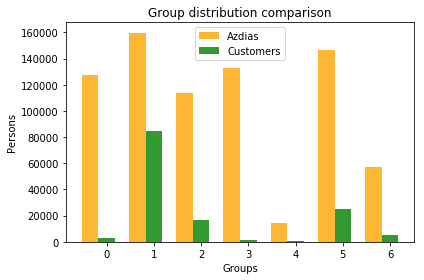

In [180]:
# data to plot
n_groups = 7
azdias_groups = azdias_kmeans_csv['closest_cluster'].value_counts().sort_index()
customers_groups = customers_kmeans_csv['closest_cluster'].value_counts().sort_index()


# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, azdias_groups, bar_width,
                alpha=opacity,
                color='orange',
                label='Azdias')

rects2 = plt.bar(index + bar_width, customers_groups, bar_width,
                alpha=opacity,
                color='g',
                label='Customers')

plt.xlabel('Groups')
plt.ylabel('Persons')
plt.title('Group distribution comparison')
plt.xticks(index + bar_width, (range(0,7)))
plt.legend()

plt.tight_layout()
plt.show()


As can be seen the majority of customers are from group 1 and 3

### 1.5 Conclusions

Select most relevant components

In [181]:
sub_cluster_centroids = cluster_centroids[range(124,len(azdias_sub_pca.columns))]

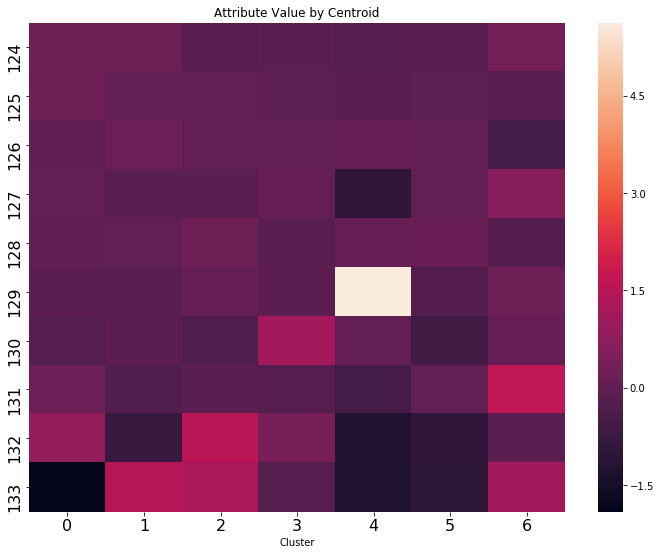

In [182]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(sub_cluster_centroids.T, cmap = 'rocket')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

With this diagram we can see that there is a strong relation between component 133 and classification in group 1 and 3,
as a reminder of the features that have weight in component 133 we can plot the feature weights

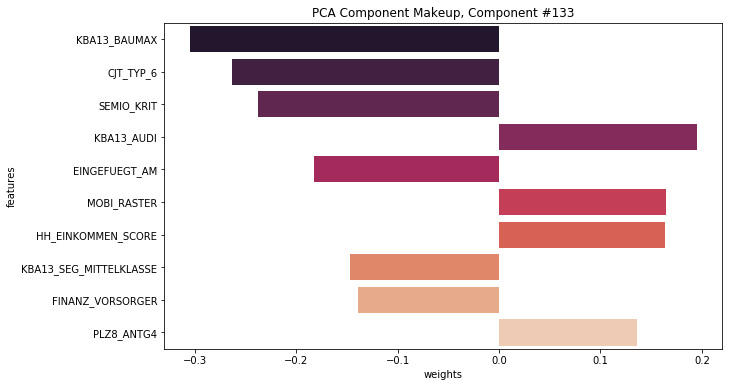

In [183]:
display_component(v, azdias_df.columns.values, component_num=133, n_components = N_COMPONENTS, n_weights=10)

From the plot above we can see that KBA13_BAUMAX, CJT_TYP_6 (from CJT_GESAMTYP, 6 Advertising enthusiast with restricted crosselling) and SEMIO_KRIT strongly negative correlated and KBA13_AUDI is positive correlated.

From the csv description of these features:
    - KBA13_BAUMAX: Number of buildings in the area (1 low - 5 high)
    - CJT_TYP_6: Customer journey type (1 Advertising & consumption minimalist - 6 Advertising enthusiast)
    - SEMIO_KRIT: Critical mind ( 1 high - 7 low)
    - KBA13_AUDI: Owner of an Audi
    

The profile we get from this info is that the buyers have a relatively high income (If they can spare to buy an Audi), live in low crowded neighbourhoods (KBA13_BAUMAX negative correlation), are Advertising and consumption minimalist (CJT_TYP_6 negative correlation) and have studies or interests (SEMIO_KRIT negative correlated)


Note: for some reason seaborn changes all the strings beginning with CJT for QT

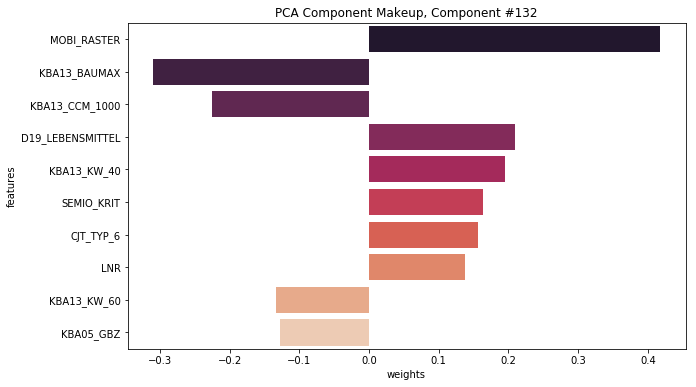

In [184]:
display_component(v, azdias_df.columns.values, component_num=132, n_components = N_COMPONENTS, n_weights=10)

From the plot above we can see that KBA13_BAUMAX and KBA13_CCM_1000 are strongly negative correlated and MOBI_RASTER is positive correlated.

From the csv description of these features:
    - KBA13_BAUMAX: Number of buildings in the area (1 low - 5 high)
    - KBA13_CCM_1000: Car with less than 1000cc 
    - MOBI_RASTER: Industrial area (1 industry - 5 residential)
    

The profile we get from this component confirms the trend that the buyers have a relatively high income (KBA13_BAUMAX negative correlation as the previous component), have some car with less than 1000cc (KBA13_CCM_1000, possibly as a second car) and live in residential cells (MOBI_RASTER positive)